In [104]:
import os
import sys
sys.path.append('../..')
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from src import cdf

**Problem**: We don’t fully understand the structure of these files and how columns relate. Therefore, after having read the netiob script, and the documentation we want to take a close look at the data itself.

**Goal**: Load xpt file into pandas in jupyter. Identify relevant columns and verify how they relate to another. For now, only for Insulin Data.

**Detailed Questions:**

1. How many patients
2. Fraction per pump system
3. Can we rely on the table as presented in T1DEXI ACRF_15Sept2022.pdf? or rather on the script?
   1. Do we have BASAL when the Bolus column is not empty?
   2. Are FATEST (test) and FACAT (category) really inconsistent between overall, 670g and 770g?
   3. Are there really no extended boluses in 770g?
   4. Is FASTRESN just a copy of the value in INSEXBOL or INSNMBOL and FAORRES (Basal)?


**How:**

- Load DX using pandas
  - unique count on USUBJID (subject counts)
  - value counts on DXTRT (patients/pump)
- Load FA (FACM) dataset
  - value counts on relevant columns
    - FATEST (insulin type)
      - INSSTYPE (subtype)
    - FATESTCD (bolus or basal category)
      - should only contain INSBASAL, INSBOLUS and BASFLRt
    - Comapre FATESTCD vs. INSDVSRC
  - Check if FAORRES (or rather FASTRESN (numeric)) result
    - is the same as either INSNMBOL, INSEXBOL

**Success:** jupyter notebook with analysis on the different columns and how they relate. Summary on where bolus, basal data is stored and differences between pumps.

## Load the xpt data file

In [129]:
t1dexi_path = os.path.join(os.getcwd(),'..','..','data','raw','T1DEXI')
dx = pd.read_sas(os.path.join(t1dexi_path,'DX.xpt'),encoding='latin-1').replace('', np.nan)
dx = dx.drop(columns=['DXSCAT','DXPRESP','STUDYID','DOMAIN','SPDEVID','DXSEQ','DXCAT','DXSCAT','DXSTRTPT','DXDTC','DXENRTPT','DXEVINTX','VISIT'])
display(dx.head())


,USUBJID,DXTRT
0,1,MULTIPLE DAILY INJECTIONS
1,1000,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM
2,1000,INSULIN PUMP
3,1004,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM
4,1004,INSULIN PUMP


In [130]:
facm = pd.read_sas(os.path.join(t1dexi_path,'FACM.xpt'),encoding='latin-1').replace('', np.nan)
#timestamps_col = timestamps_col.apply(lambda x: datetime(1960, 1, 1) + timedelta(seconds=x) if pd.notnull(x) else pd.NaT)
facm['FADTC'] = facm['FADTC'].apply(lambda x: datetime(1960, 1, 1) + timedelta(seconds=x) if pd.notnull(x) else pd.NaT)
facm = facm.drop(columns=['STUDYID','DOMAIN','FASEQ'])

#note, we didn't need to replace % signs and we didn't need xport as in the scripts
percent_count_facm = facm.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
percent_count_dx = dx.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
print(f'Number of % in facm: {percent_count_facm}, dx: {percent_count_dx}')

display(facm.head())

Number of % in facm: 0, dx: 0


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FASTRESC,FASTRESN,FASTRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL
0,1,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,NaN,NaN,NaN,2020-05-11 23:12:21,NaN,NaN,NaN,NaN,NaN
1,1,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,NaN,NaN,NaN,2020-05-12 07:09:22,NaN,NaN,NaN,NaN,NaN
2,1,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,NaN,NaN,NaN,2020-05-13 08:35:47,NaN,NaN,NaN,NaN,NaN
3,1,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,NaN,NaN,NaN,2020-05-14 06:50:24,NaN,NaN,NaN,NaN,NaN
4,1,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,NaN,NaN,NaN,2020-05-15 00:02:21,NaN,NaN,NaN,NaN,NaN


## Inspect DX (Patients and Pumps)

In [76]:
#the duplicated 'INSULIN PUMP' or 'CLOSED LOOP INSULIN PUMP' values can be used to specify the pump type
pump_type = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])][['USUBJID','DXTRT']]
mdi_type = dx.loc[dx.DXTRT.isin(['MULTIPLE DAILY INJECTIONS'])]
other_type = dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])]
#print lentths of each
print(f'Pump: {len(pump_type)}, MDI: {len(mdi_type)}, Other: {len(other_type)}')

#use the redundant rows as treatment type and add those to new TRTMNT Colum (CSII, AID, MDI)
treatment_type = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])][['USUBJID','DXTRT']].rename(columns={'DXTRT':'TRTMNT'})
treatment_type['TRTMNT'] = treatment_type.TRTMNT.replace({'INSULIN PUMP':'CSII','CLOSED LOOP INSULIN PUMP':'AID','MULTIPLE DAILY INJECTIONS':'MDI'})
dx = pd.merge(dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])], treatment_type, on='USUBJID',how='inner')
#display(dx.head())

#reduce
dx = dx[['USUBJID','TRTMNT','DXTRT']]
display(dx.head())

Pump: 414, MDI: 88, Other: 414


,USUBJID,TRTMNT,DXTRT
0,1,MDI,MULTIPLE DAILY INJECTIONS
1,1000,CSII,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM
2,1004,CSII,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM
3,1010,CSII,MEDTRONIC 670G IN MANUAL MODE
4,1012,AID,TANDEM T:SLIM X2 WITH CONTROL IQ


In [77]:
#There are duplicated generic INSULIN PUMP rows
print(f'There are {dx.USUBJID.nunique()} unique subjects in the dx dataset')
print('These are broken down by devices as follows:')
#dx.groupby('DXTRT').agg({'USUBJID':'nunique'}).sort_values(by='USUBJID',ascending=False)
display(dx.value_counts('DXTRT'))
dx.value_counts(['TRTMNT','DXTRT'],sort=False)

There are 502 unique subjects in the dx dataset
These are broken down by devices as follows:


DXTRT
TANDEM T:SLIM X2 WITH CONTROL IQ             190
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM    106
MULTIPLE DAILY INJECTIONS                     88
MEDTRONIC 670G IN AUTO MODE                   33
TANDEM T:SLIM X2 WITH BASAL IQ                23
MEDTRONIC 670G IN MANUAL MODE                 21
MEDTRONIC 630G                                 9
TANDEM T:SLIM X2                               8
TANDEM T:SLIM                                  5
MEDTRONIC PARADIGM 723 (REVEL)                 4
MEDTRONIC 670G                                 3
MEDTRONIC 770G                                 2
MEDTRONIC 770G IN AUTO MODE                    2
MEDTRONIC 751 (530G)                           2
MEDTRONIC 551 (530G)                           2
MEDTRONIC PARADIGM 523 (REVEL)                 1
MEDTRONIC PARADIGM 522                         1
MEDTRONIC 640G                                 1
INSULET OMNIPOD DASH                           1
Name: count, dtype: int64

TRTMNT  DXTRT                                    
AID     MEDTRONIC 670G IN AUTO MODE                   32
        MEDTRONIC 770G                                 1
        MEDTRONIC 770G IN AUTO MODE                    2
        TANDEM T:SLIM X2 WITH CONTROL IQ             190
CSII    INSULET OMNIPOD DASH                           1
        INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM    106
        MEDTRONIC 551 (530G)                           2
        MEDTRONIC 630G                                 9
        MEDTRONIC 640G                                 1
        MEDTRONIC 670G                                 3
        MEDTRONIC 670G IN AUTO MODE                    1
        MEDTRONIC 670G IN MANUAL MODE                 21
        MEDTRONIC 751 (530G)                           2
        MEDTRONIC 770G                                 1
        MEDTRONIC PARADIGM 522                         1
        MEDTRONIC PARADIGM 523 (REVEL)                 1
        MEDTRONIC PARADIGM 723 (REVEL)

We can see some inconsistent classificaitons:  
 - 770G in the AID section is probably a 770G in Auto MODE
 - TANDEM T:SLIM X2 WITH BASAL IQ in the CSII are probably AID
 - MEDTRONIC 670G IN AUTO MODE in CSII are probably AID instead

So, can we trust this list? The netiob scripts made the following observation:  
>[Discretional]. We observed that subject ID: 766 device type should be 'MEDTRONIC 770G IN AUTO MODE' and we updated as such
        device_data.loc[device_data['USUBJID'] == '766', 'DXTRT'] = 'MEDTRONIC 770G IN AUTO MODE'

However, there are also many TANDEM with BASAL IQ, these could probbaly also be considered to be AID. Ultimately, the netiob script assigned the treatment based on the DXTRT name alone.   

**Conclusion**: ATM we don't know which one to use.

## FACM

- Load FA (FACM) dataset
  - value counts on relevant columns
    - FATEST (insulin type)
      - INSSTYPE (subtype)
    - FATESTCD (bolus or basal category)
      - should only contain INSBASAL, INSBOLUS and BASFLRt
    - Comapre FATESTCD vs. INSDVSRC
  - Check if FAORRES (or rather FASTRESN (numeric)) result
    - is the same as either INSNMBOL, INSEXBOL

In [ ]:
display(facm.head(2))
print(f'Overall number of rows is {facm.shape[0]}')

vcounts= facm.value_counts(subset=['FAOBJ','FACAT','FATESTCD','FATEST','INSDVSRC','INSSTYPE'],sort=False,dropna=False)
display(vcounts)

#We see that source and sub type are NaN when fatest is basal flow rate. So do the units differ?
vcounts = facm.value_counts(subset=['FATEST','INSDVSRC','FAORRESU'],sort=False,dropna=False)
display(vcounts)

#units
facm.value_counts(['FAORRESU','FASTRESU'],sort=False,dropna=False)

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FASTRESC,FASTRESN,FASTRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL
0,1,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,NaN,NaN,NaN,2020-05-11 23:12:21,NaN,NaN,NaN,NaN,NaN
1,1,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,NaN,NaN,NaN,2020-05-12 07:09:22,NaN,NaN,NaN,NaN,NaN


Overall number of rows is 2219524


FAOBJ    FACAT  FATESTCD  FATEST           INSDVSRC    INSSTYPE                  
INSULIN  BASAL  BASFLRT   BASAL FLOW RATE  NaN         NaN                           1053401
                INSBASAL  BASAL INSULIN    Injections  NaN                              2365
                                           Pump        automated                      237033
                                                       scheduled                      258749
                                                       suspend                         14457
                                                       temp                           537986
                                                       NaN                              2811
         BOLUS  INSBOLUS  BOLUS INSULIN    Injections  NaN                              9516
                                           Pump        automated                        1619
                                                       automatic bolus/correction

FATEST           INSDVSRC    FAORRESU
BASAL FLOW RATE  NaN         U/hr        1053401
BASAL INSULIN    Injections  U              2365
                 Pump        U           1051036
BOLUS INSULIN    Injections  U              9516
                 Pump        U            103206
Name: count, dtype: int64

FAORRESU  FASTRESU
U         U           1166123
U/hr      NaN         1053401
Name: count, dtype: int64

- #FAORRESU and FASTRESU are both the basal units. However, when FAORRESU is "U/hr" FASTRESU is NaN. So should we only rely on `FAORRESU`?

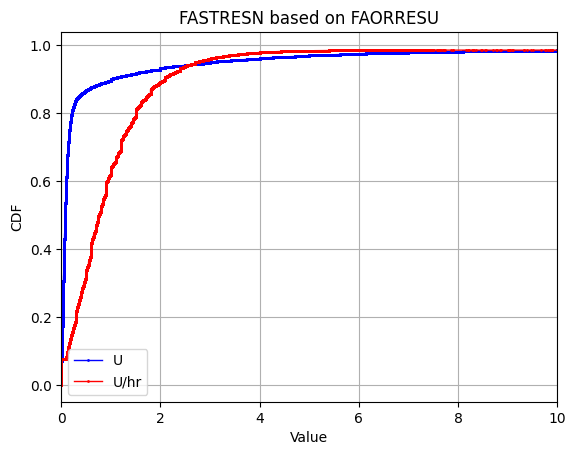

In [110]:
#what is the difference between basals in units and units/h, is there any diff?
# numeric value = FASTRESN
# unit = FAORRESU
plt.figure();ax=plt.gca()
cdf.plot_cdf(facm.loc[facm.FAORRESU=='U'].FASTRESN,ax=ax,color='blue',label='U')
cdf.plot_cdf(facm.loc[facm.FAORRESU=='U/hr'].FASTRESN,ax=ax,color='red',label='U/hr')
ax.set_xlim(0,10)
plt.title('FASTRESN based on FAORRESU'); ax.legend()

So, which ones should we use and when are U and when U/hr reported. The script only considers FATEST == 'BASAL INSULIN' thus ignoring BASAL FLOW RATE. Is this correct? Maybe the difference is based on the pump model? Let's check.

In [ ]:
#as we see here, BASAL FLOW RATE and BASAL are present in all pumps
facm_merged = pd.merge(facm,dx,on='USUBJID',how='inner')
facm_merged.loc[facm_merged.FATEST=='BASAL FLOW RATE'].value_counts(subset=['FATEST','DXTRT'],sort=False,dropna=False)

FATEST           DXTRT                                    
BASAL FLOW RATE  INSULET OMNIPOD DASH                            198
                 INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM     17425
                 MEDTRONIC 551 (530G)                            448
                 MEDTRONIC 630G                                 1862
                 MEDTRONIC 640G                                  503
                 MEDTRONIC 670G                                  493
                 MEDTRONIC 670G IN AUTO MODE                  150612
                 MEDTRONIC 670G IN MANUAL MODE                  6370
                 MEDTRONIC 751 (530G)                            472
                 MEDTRONIC 770G                                 1122
                 MEDTRONIC 770G IN AUTO MODE                     416
                 MEDTRONIC PARADIGM 522                          188
                 MEDTRONIC PARADIGM 523 (REVEL)                  146
                 MEDTRONIC PARADIGM 723 (REV

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FASTRESC,FASTRESN,FASTRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL
2203565,988,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.3600000143,U/hr,0.3600000143,0.360,NaN,2021-03-21 00:00:00,P0Y0M0DT0H3M54S,NaN,NaN,NaN,NaN
2211517,988,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.0230000000,U,0.0230000000,0.023,U,2021-03-21 00:00:00,P0Y0M0DT0H3M54S,Pump,scheduled,NaN,NaN
2211518,988,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.0300000000,U,0.0300000000,0.030,U,2021-03-21 00:03:54,P0Y0M0DT0H5M2S,Pump,scheduled,NaN,NaN
2203566,988,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.3600000000,U/hr,0.3600000000,0.360,NaN,2021-03-21 00:03:54,P0Y0M0DT0H5M2S,NaN,NaN,NaN,NaN
2203567,988,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.3600000000,U/hr,0.3600000000,0.360,NaN,2021-03-21 00:08:56,P0Y0M0DT0H5M0S,NaN,NaN,NaN,NaN
2211519,988,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.0300000000,U,0.0300000000,0.030,U,2021-03-21 00:08:56,P0Y0M0DT0H5M0S,Pump,scheduled,NaN,NaN
2211520,988,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.0300000000,U,0.0300000000,0.030,U,2021-03-21 00:13:56,P0Y0M0DT0H5M1S,Pump,scheduled,NaN,NaN
2203568,988,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.3600000000,U/hr,0.3600000000,0.360,NaN,2021-03-21 00:13:56,P0Y0M0DT0H5M1S,NaN,NaN,NaN,NaN
2211521,988,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.0300000000,U,0.0300000000,0.030,U,2021-03-21 00:18:57,P0Y0M0DT0H5M0S,Pump,scheduled,NaN,NaN
2203569,988,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.3600000000,U/hr,0.3600000000,0.360,NaN,2021-03-21 00:18:57,P0Y0M0DT0H5M0S,NaN,NaN,NaN,NaN


,count,<lambda_0>
FATEST,,
BASAL FLOW RATE,141,1
BASAL INSULIN,141,1
BOLUS INSULIN,3,0


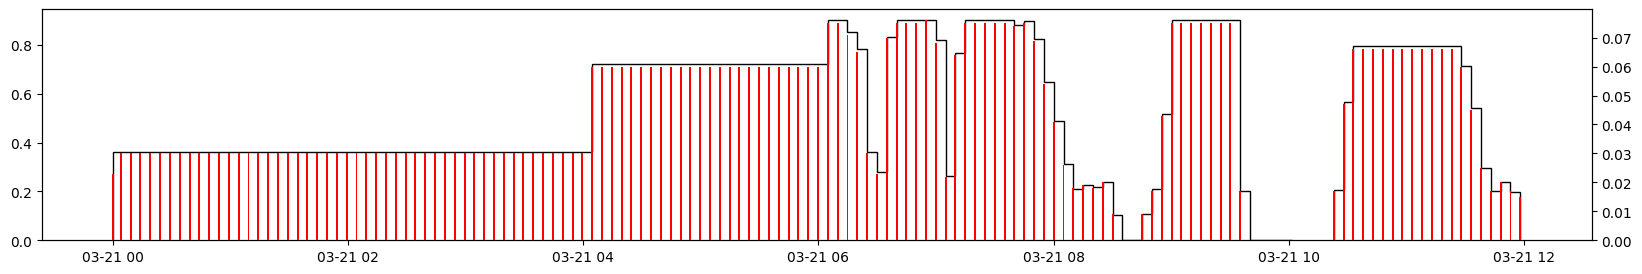

In [196]:
from src import drawing
from importlib import reload
reload(drawing)
#show an example of a flow rate and a basal within the same subject
sub = facm.loc[(facm.USUBJID=='988')&(facm.FATEST.notna())]
sub = sub.sort_values('FADTC')
start = sub.FADTC.min()+timedelta(days=1)
dur = timedelta(hours=12)
sub = sub.loc[(sub.FADTC>=start)&(sub.FADTC<=start+dur)]

display(sub.head(15))
display(sub.groupby('FATEST')['FASTRESN'].agg(['count', lambda x: x.isna().sum()]))

sub_flow_rates = sub.loc[sub.FATEST=='BASAL FLOW RATE']
sub_basals = sub.loc[sub.FATEST=='BASAL INSULIN']


plt.figure(figsize=(20,3)); ax=plt.gca()
#drawing.drawAbsoluteBasalRates()
drawing.drawAbsoluteBasalRates(ax,sub_flow_rates.FADTC.values, sub_flow_rates.FASTRESN.values,label='U/hr',hatch=None)
twinx = ax.twinx()
drawing.drawBoluses(twinx,sub_basals.FADTC, sub_basals.FASTRESN,label='U',width=timedelta(minutes=1))


Aparently
- MDI patients have NaN BASAL FLOW RATE rows
- FASTRESU and FAORRESU do not always align, When it is "U" they seem to have the same value but when FAORRESU is "U/hr" FASTRESU is NaN
- The BASAL deliveries happen every 5 minutes and module the basal rate (U/hr) (at least in the example above)
    - we can check by calculating the sum (using U/hr and duration) and compare it to the sum obtained on all basal values (U)

## Collected Questions
- Why are `TANDEM T:SLIM X2 WITH BASAL IQ` not considered AID?
- How do we know if Pump was running AID or not?
- The script only considers FATEST == 'BASAL INSULIN' thus ignoring BASAL FLOW RATE. Is this correct?
- Why are there many rows with NaN values in `FASTRESN` despite FATEST being BASAL INSULIN or BASAL FLOW RATE?  
- Why is FASTRES Nan when FAORRESU is U/hr but not when it is U?
